In [5]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [6]:
# collection data from API
fields = {'fields': 'name'}
r = requests.get("https://restcountries.com/v3.1/all", params=fields)
r.status_code

200

In [9]:
# needs MongoDB installed locally
client = pymongo.MongoClient("mongodb://localhost:27017/")

# create Database called Countries
db = client['Countries']

# no db is created until we publish any data
client.list_database_names()

['admin', 'config', 'local']

In [10]:
# create names collection in Countries db
names = db.names

# publish all the data from the requests to names collection
db.names.insert_many(r.json())

InsertManyResult([ObjectId('676c8e56c33bd7b879a1918c'), ObjectId('676c8e56c33bd7b879a1918d'), ObjectId('676c8e56c33bd7b879a1918e'), ObjectId('676c8e56c33bd7b879a1918f'), ObjectId('676c8e56c33bd7b879a19190'), ObjectId('676c8e56c33bd7b879a19191'), ObjectId('676c8e56c33bd7b879a19192'), ObjectId('676c8e56c33bd7b879a19193'), ObjectId('676c8e56c33bd7b879a19194'), ObjectId('676c8e56c33bd7b879a19195'), ObjectId('676c8e56c33bd7b879a19196'), ObjectId('676c8e56c33bd7b879a19197'), ObjectId('676c8e56c33bd7b879a19198'), ObjectId('676c8e56c33bd7b879a19199'), ObjectId('676c8e56c33bd7b879a1919a'), ObjectId('676c8e56c33bd7b879a1919b'), ObjectId('676c8e56c33bd7b879a1919c'), ObjectId('676c8e56c33bd7b879a1919d'), ObjectId('676c8e56c33bd7b879a1919e'), ObjectId('676c8e56c33bd7b879a1919f'), ObjectId('676c8e56c33bd7b879a191a0'), ObjectId('676c8e56c33bd7b879a191a1'), ObjectId('676c8e56c33bd7b879a191a2'), ObjectId('676c8e56c33bd7b879a191a3'), ObjectId('676c8e56c33bd7b879a191a4'), ObjectId('676c8e56c33bd7b879a191

In [11]:
client.list_database_names()

['Countries', 'admin', 'config', 'local']

In [12]:
r.json()[0] # schema

{'name': {'common': 'South Georgia',
  'official': 'South Georgia and the South Sandwich Islands',
  'nativeName': {'eng': {'official': 'South Georgia and the South Sandwich Islands',
    'common': 'South Georgia'}}}}

In [16]:
names.count_documents({}) # count the number of countries

250

In [21]:
query = {
    "name.official" : {"$regex": "(Republic|Democratic|Socialist|People)"}
}

names.count_documents(query) # how many countries call themselves as Republic etc

133

In [30]:
query = {
    "name.official" : {"$regex": "Socialist"}
}

projection = {
    "name.official": 1, "_id": 0
}

results = names.find(query, projection)

for doc in results:
    print(doc.get('name').get('official')) # find out the name of Socialists

Democratic Socialist Republic of Sri Lanka
Socialist Republic of Vietnam


In [31]:
query = {
    "name.official" : {"$regex": "(Democratic|People)"}
}

projection = {
    "name.official": 1, "_id": 0
}

results = names.find(query, projection)

for doc in results:
    print(doc.get('name').get('official')) # find out name sake democracies

Lao People's Democratic Republic
People's Republic of China
Democratic Socialist Republic of Sri Lanka
People's Republic of Bangladesh
Democratic People's Republic of Korea
People's Democratic Republic of Algeria
Federal Democratic Republic of Nepal
Democratic Republic of São Tomé and Príncipe
Federal Democratic Republic of Ethiopia
Macao Special Administrative Region of the People's Republic of China
Sahrawi Arab Democratic Republic
Democratic Republic of the Congo
Democratic Republic of Timor-Leste
Hong Kong Special Administrative Region of the People's Republic of China


In [42]:
# distribution of countries by native names as proxy to official languages
# spoken in the country

pipeline = [
    { # Stage 1: count number of nativeNames
        "$project" : {
            "numFields": {"$size": {"$objectToArray": "$name.nativeName"}}
        }
    },

    { # group the number of native names and count frequency
        "$group": {
            "_id": "$numFields",
            "count": {"$sum": 1}
        }
    },

    {
        "$sort": {"_id": 1}
    }

]


numNativeLang = [doc for doc in names.aggregate(pipeline)]

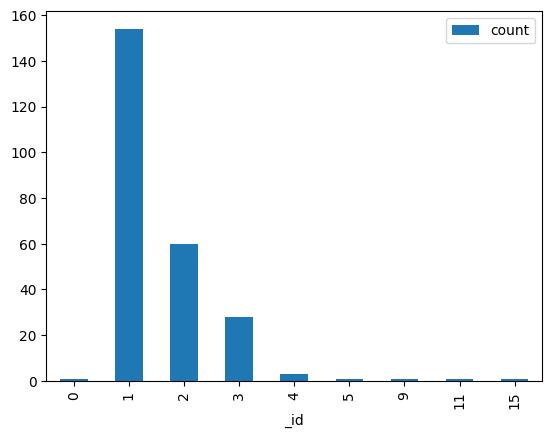

In [49]:
pd.DataFrame(numNativeLang).plot(x='_id', y='count', kind='bar');

In [58]:
pipeline = [
    {
        "$project": {
            "numFields": { "$size": { "$objectToArray": "$name.nativeName" } },
        }
    },
    {
        "$group": {
            "_id": None,
            "maxNumFields": { "$max": "$numFields" },
            "minNumFields": { "$min": "$numFields" },
        }
    },
]

# Step 5: Execute the aggregation to find max and min _id
max_min_result = list(names.aggregate(pipeline))

max_min_result

[{'_id': None, 'maxNumFields': 15, 'minNumFields': 0}]

In [68]:
def find_by_native_name_count(n=1):
    pipeline = [
        {
            "$project": {
                "numFields": { "$size": { "$objectToArray": "$name.nativeName" } },
                "name.common": 1,
                "name.nativeName": 1
            }
        },
        {
            "$match": {
                "numFields": n  # Filter documents where numFields is equal to 1
            }
        }
    ]
    return list(names.aggregate(pipeline))

find_by_native_name_count(15)    

[{'_id': ObjectId('676c8e56c33bd7b879a1927b'),
  'name': {'common': 'Zimbabwe',
   'nativeName': {'bwg': {'official': 'Republic of Zimbabwe',
     'common': 'Zimbabwe'},
    'eng': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'kck': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'khi': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'ndc': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'nde': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'nya': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'sna': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'sot': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'toi': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'tsn': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'tso': {'official': 'Republic of Zimbabwe', 'common': 'Zimbabwe'},
    'ven': {'official': 'Republic of Zimbabwe', '

In [69]:
find_by_native_name_count(0)

[{'_id': ObjectId('676c8e56c33bd7b879a191ce'),
  'name': {'common': 'Antarctica', 'nativeName': {}},
  'numFields': 0}]

In [70]:
find_by_native_name_count(11)

[{'_id': ObjectId('676c8e56c33bd7b879a191a1'),
  'name': {'common': 'South Africa',
   'nativeName': {'afr': {'official': 'Republiek van Suid-Afrika',
     'common': 'South Africa'},
    'eng': {'official': 'Republic of South Africa', 'common': 'South Africa'},
    'nbl': {'official': 'IRiphabliki yeSewula Afrika',
     'common': 'Sewula Afrika'},
    'nso': {'official': 'Rephaboliki ya Afrika-Borwa ',
     'common': 'Afrika-Borwa'},
    'sot': {'official': 'Rephaboliki ya Afrika Borwa',
     'common': 'Afrika Borwa'},
    'ssw': {'official': 'IRiphabhulikhi yeNingizimu Afrika',
     'common': 'Ningizimu Afrika'},
    'tsn': {'official': 'Rephaboliki ya Aforika Borwa',
     'common': 'Aforika Borwa'},
    'tso': {'official': 'Riphabliki ra Afrika Dzonga',
     'common': 'Afrika Dzonga'},
    'ven': {'official': 'Riphabuḽiki ya Afurika Tshipembe',
     'common': 'Afurika Tshipembe'},
    'xho': {'official': 'IRiphabliki yaseMzantsi Afrika',
     'common': 'Mzantsi Afrika'},
    'zul': {

In [83]:
# most common language amount all the countries

pipeline = [
    {
        "$project": {
            "lang": { "$objectToArray": "$name.nativeName" },
        }
    },

    {
        "$unwind": "$lang"
    },

    {
        "$group": {
            "_id" : "$lang.k",
            "count": {"$sum": 1}
        }
    },

    {
        "$sort": {"count": -1}
    }
]

lang_count = pd.DataFrame(list(names.aggregate(pipeline))).rename(columns={'_id': 'language'})
lang_count.head()

,language,count
0,eng,90
1,fra,46
2,ara,25
3,spa,24
4,por,10


<Axes: ylabel='language'>

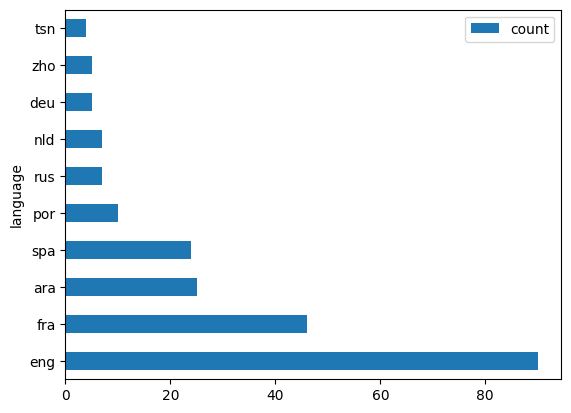

In [90]:
# top ten most used languages
lang_count.iloc[:10].plot(x='language', y='count', kind='barh')

In [91]:
lang_count.size

306

In [102]:
pipeline = [
    {
        "$project": {
            "wordCount": {"$size": {"$split": ["$name.common", " "]}}
        }
    },

    {
        "$group": {
            "_id": "$wordCount",
            "count": {"$sum": 1}
        }
    },

    {
        "$sort": {"_id": 1}
    }

]

list(names.aggregate(pipeline))

[{'_id': 1, 'count': 181},
 {'_id': 2, 'count': 45},
 {'_id': 3, 'count': 11},
 {'_id': 4, 'count': 8},
 {'_id': 5, 'count': 4},
 {'_id': 7, 'count': 1}]

In [105]:
# find the longest common name of a country

pipeline = [
    {
        "$project": {
            "wordCount": {"$size": {"$split": ["$name.common", " "]}},
            "country" : "$name.common"
        }
    },

    {
        "$match": {
            "wordCount": 7
        }
    }

]

list(names.aggregate(pipeline))

[{'_id': ObjectId('676c8e56c33bd7b879a19227'),
  'wordCount': 7,
  'country': 'Saint Helena, Ascension and Tristan da Cunha'}]